In [1]:
#20221026 最新版
#3kHz~13の0.3s間隔のプログラム

#・speaker_heightsを変更して角度を基準にした。
import time
import wave
import scipy as sp
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy.fftpack import fft
import scipy.signal as sg
from scipy import signal
import pandas as pd
import scipy.interpolate as itpl
# import resampy
import math
import seaborn as sns
# import japanize_matplotlib
from matplotlib.colors import LogNorm
from matplotlib.colors import LinearSegmentedColormap
# from numba import jit
#6kHz~16kHzにチャープ信号を変更
#データベースは10回分の平均で作成

#信号読み込み
#データベース生成
#測位
#変更点
#・データベースの数
#・周波数帯(14kHz-24kHz)
#・np.zeros(144*10*81*76).reshape(81,76,144*10)
#・speaker_heights[6] -> 0,17,34,50,64,75

#相互相関を見直す
#使用する帯域祖14~22kHzに変更

def chirp_exp(numSamples, chirpLen_s, start_Hz, stop_Hz, phase_rad):
    # チャープの生成関数,chirpaは生成したチャープ信号の配列を返す
    times_s = np.linspace(0, chirpLen_s, numSamples) # Chirp times.
    k = (stop_Hz - start_Hz) / chirpLen_s # Chirp rate.
    sweepFreqs_Hz = (start_Hz + k/2. * times_s) * times_s
    chirpa = np.array(np.exp(phase_rad*1j-2*np.pi*1j*sweepFreqs_Hz))
    return chirpa

def readwav(file1):
    wr = wave.open(file1, 'r')
    # waveファイルが持つ性質を取得
    ch = wr.getnchannels()
    width = wr.getsampwidth()
    fr = wr.getframerate()
    fn = wr.getnframes()
    data = wr.readframes(wr.getnframes())
    wr.close()
    X = np.frombuffer(data, dtype=np.int16)
    # 波全体の時間幅
    t = np.arange(0,len(X))/int(fr)
    # 1秒間の時間幅
    t_1sec = np.arange(0,int(fr))/int(fr)
    # 時間刻み幅
    dt = 1/int(fr)
    # 開始時間の指標
    start = int(2.0/dt)
    # 終了時間の指標
    end = int(5.0/dt)
    # plt.plot(t_1sec,X_1sec)
    return X


In [2]:
def create_db():
    #1回分をかさねあわせてる
    sound_db1 = np.zeros(6*10*81*51).reshape(81,51,6*10)
    sound_db2 = np.zeros(144*10*81*51).reshape(81,51,144*10)
    sound_db3 = np.zeros(144*10*81*51).reshape(81,51,144*10)
    sound_db4 = np.zeros(144*10*81*51).reshape(81,51,144*10)
    sound_db5 = np.zeros(144*10*81*51).reshape(81,51,144*10)
    sound_db6 = np.zeros(144*10*81*51).reshape(81,51,144*10)
    sound_db7 = np.zeros(144*10*81*51).reshape(81,51,144*10)
    sound_db8 = np.zeros(144*10*81*51).reshape(81,51,144*10)
    sound_db9 = np.zeros(144*10*81*51).reshape(81,51,144*10)
    sound_db10 = np.zeros(144*10*81*51).reshape(81,51,144*10)
    sound_db = np.zeros(144*10*81*51).reshape(81,51,144*10)
    sound_db1[:,:,:] = np.nan
    sound_db2[:,:,:] = np.nan
    sound_db3[:,:,:] = np.nan
    sound_db4[:,:,:] = np.nan
    sound_db5[:,:,:] = np.nan
    sound_db6[:,:,:] = np.nan
    sound_db7[:,:,:] = np.nan
    sound_db8[:,:,:] = np.nan
    sound_db9[:,:,:] = np.nan
    sound_db10[:,:,:] = np.nan
    sound_db[:,:,:] = np.nan
    
    dbs = [sound_db1,sound_db2,sound_db3,sound_db4,sound_db5,sound_db6,sound_db7,sound_db8,sound_db9,sound_db10]
    times = 150000
    for e in range(0,1):
        #times += 50000
        speaker_height = 0
        for h in range(0,6):
            mic_deg = -40
            for i in range(0,9):
                # wav読み込み
                sound_sample = readwav('vivesound_0817/s'+str(speaker_height)+'m'+str(mic_deg)+'.wav')
                start_hz = 3000
                #最初の帯域(3~4kHz)のみfor文の外でまわしてindex_fを固定
                #チャープ信号の生成
                chirp = chirp_exp(144,0.003,start_hz,start_hz+1000,np.pi*0.5)
                # 相互相関
                corr = sg.correlate(sound_sample[times:times+50000*4],chirp,mode='same',method='auto')
                #最大値のインデックス見つける
                index_f = corr.argmax()
                #1つ分の波の抽出
                X_1sec = sound_sample[times+index_f-72:times+index_f+72]
                X_1sec = (X_1sec) - (sum(X_1sec)/len(X_1sec))
                # FFT
                #X_fft = np.abs(fft(X_1sec))
                # データベース構築
                sound_db1[mic_deg+40,speaker_heights[h],0:6] = abs(fft(X_1sec)[8:14])
                start_hz += 1000
                start_sample = 12
                for j in range(1,10):
                    #チャープ信号の生成
                    chirp = chirp_exp(144,0.003,start_hz,start_hz+1000,np.pi*0.5)
                    # 相互相関
                    corr = sg.correlate(sound_sample[times+index_f:times+index_f+50000*4],chirp,mode='same',method='auto')
                    #最大値のインデックス見つける
                    index = corr.argmax()
                    #1つ分の波の抽出
                    X_1sec = sound_sample[times+index_f+index-72:times+index_f+index+72]
                    X_1sec = (X_1sec) - (sum(X_1sec)/len(X_1sec))
                    test_x = np.linspace(0,50000,len(X_1sec))
                    #plt.plot(test_x,abs(fft(X_1sec)))
                    #plt.xlim(0,25000)
                    #plt.show()
                    # FFT
                    #X_fft = np.abs(fft(X_1sec))
                    # データベース構築
                    sound_db1[mic_deg+40,speaker_heights[h],0+j*6:6+j*6] = abs(fft(X_1sec)[start_sample-1:start_sample+5])
                    start_hz += 1000
                    start_sample += 3
                mic_deg += 10
            speaker_height += 10

    #sound_db =　np.concatenate([sound_db1,sound_db2,sound_db3,sound_db4,sound_db5,sound_db6,sound_db7,sound_db8,sound_db9,sound_db10], 0)    
    
    #検証コード
    colorlist = ["r", "g", "b", "y", "c", "gray","orangered","magenta","purple","sienna"]
    dbtest_x = np.linspace(0,60,60)
    plt.plot(dbtest_x,sound_db1[10,30,:],color=colorlist[0],label="sound_db1",alpha=0.3)
    '''
    plt.plot(dbtest_x,sound_db2[10,30,:],color=colorlist[1],label="sound_db2",alpha=0.3)
    plt.plot(dbtest_x,sound_db3[10,30,:],color=colorlist[2],label="sound_db3",alpha=0.3)
    plt.plot(dbtest_x,sound_db4[10,30,:],color=colorlist[3],label="sound_db4",alpha=0.3)
    plt.plot(dbtest_x,sound_db5[10,30,:],color=colorlist[4],label="sound_db5",alpha=0.3)
    plt.plot(dbtest_x,sound_db6[10,30,:],color=colorlist[5],label="sound_db6",alpha=0.3)
    plt.plot(dbtest_x,sound_db7[10,30,:],color=colorlist[6],label="sound_db7",alpha=0.3)
    plt.plot(dbtest_x,sound_db8[10,30,:],color=colorlist[7],label="sound_db8",alpha=0.3)
    plt.plot(dbtest_x,sound_db9[10,30,:],color=colorlist[8],label="sound_db9",alpha=0.3)
    plt.plot(dbtest_x,sound_db10[10,30,:],color=colorlist[9],label="sound_db10",alpha=0.3)
    '''
    plt.show()
    
    sound_db = sound_db1
    #sound_db = (sound_db1 + sound_db2 + sound_db3 + sound_db4 + sound_db5 + sound_db6 + sound_db7 + sound_db8 + sound_db9 + sound_db10)/10
    #sound_db = abs(fft(sound_db))
    #ここから秋間補間，マイク方位で補間した後スピーカ高さで補間
    Akima = np.zeros(6*10*81*51).reshape(81,51,6*10)
    Akima[:,:,:] = np.nan
    #マイク方位で補間
    count = 0
    for j in range(0,6):
        sound_db_d = pd.DataFrame(sound_db[:,speaker_heights[j],:])
        sound_db_d.astype('float64')
        Akima[:,speaker_heights[j],:] = sound_db_d.interpolate('akima')
        #count += 25

    #スピーカ高さで補間
    for i in range(0,81):
        sound_db_d = pd.DataFrame(Akima[i,:,:])
        sound_db_d.astype('float64')
        Akima[i,:,:] = sound_db_d.interpolate('akima')
    #Akima = pd_Zrf_d.interpolate('akima')
    print('Akima done!!')
    return Akima
    
# 残差平方和
def rss(y, t):
    f = np.sum((y-t).T*(y-t))
    return f

def normalzie(x, amin=0, amax=1):
    xmax = x.max()
    xmin = x.min()
    if xmin == xmax:
        return np.ones_like(x)
    return (amax - amin) * (x - xmin) / (xmax - xmin) + amin

#normalized_x = normalzie(x, amin=-1, amax=1)
  

In [3]:
def estimate(db,file):
    
    #データベースを読み込んで、残差平方和を計測
    rss_db = np.zeros(81*51).reshape(81,51)
    file_db = np.zeros(6*10)
    #計測データを切り抜き
    start_hz = 3000
    #最初の帯域(10kHz)のみfor文の外でまわしてindexを固定
    #チャープ信号の生成
    chirp = chirp_exp(144,0.003,start_hz,start_hz+1000,np.pi*0.5)
    # 相互相関
    corr = sg.correlate(file[sec:sec+50000*4],chirp,mode='same',method='auto')
    #最大値のインデックス見つける
    index_f = corr.argmax()
    #1つ分の波の抽出
    X_1sec = file[sec+index_f-72:sec+index_f+72]
    X_1sec = (X_1sec) - (sum(X_1sec)/len(X_1sec))
    # FFT
    X_fft = abs(fft(X_1sec)[8:14])
    file_db[0:6] = X_fft
    start_hz += 1000
    start_sample = 12
    for j in range(1,10):
        #チャープ信号の生成
        chirp = chirp_exp(144,0.003,start_hz,start_hz+1000,np.pi*0.5)
        # 相互相関
        corr = sg.correlate(file[sec+index_f:sec+index_f+50000*4], chirp, mode='same', method='auto')
        #最大値のインデックス見つける
        index = corr.argmax()
        #1つ分の波の抽出
        X_1sec = file[sec+index_f+index-72:sec+index_f+index+72]
        X_1sec = (X_1sec) - (sum(X_1sec)/len(X_1sec))
        # FFT
        X_fft = abs(fft(X_1sec)[start_sample-1:start_sample+5])
        file_db[j*6:6+j*6] = X_fft
        start_hz += 1000
        start_sample += 3
    #print(file_db)
    #print(db)
    #窓関数をかける
    #N = len(file_db) #入力データの数=横軸のmax
    #window_n = np.hanning(N)
    
    #fft_db = abs(fft(db*window_n))
    #fft_file_db = abs(fft(file_db*window_n))
    fft_db = db
    fft_file_db = file_db
    
    
    '''
    for j in range(0,81):
        for i in range(0,76):
            rss_ans = rss(normalzie(fft_db[j,i],0,1),normalzie(fft_file_db[:],0,1))
            rss_db[j,i] = rss_ans
    #print('rss_db'+str(rss_db[26,71]))
    #残差平方和の値のヒートマップだすためのプログラム
    '''
    """
    """
    
    #base = fft_db[0,0]
    base = fft_file_db
    for j in range(0,81):
        for i in range(0,51):
            rss_ans = rss(normalzie(fft_db[j,i],0,1),normalzie(base,0,1))
            #rss_ans = rss(fft_db[j,i],base[:])
            rss_db[j,i] = rss_ans
    pd.set_option('display.max_rows',100)
    pd.set_option('display.max_columns',100)
    #print('rss_db[0]:'+str(rss_db[0]))
    
    ####
    estimate_mic_speaker = np.unravel_index(np.argmin(rss_db), rss_db.shape)
    estimate_mic_speaker = list(estimate_mic_speaker)
    ####
    max_rss = rss_db.max()
    rss_db = (rss_db/max_rss)*100
    
    dff = pd.DataFrame(rss_db)
    '''
    # data
    bounds = [0.1, 0.25, 0.5, 1, 2.5, 5, 7.5, 10, 15, 20, 25, 50, 100]
    style_color = [[0, 0, 127],
                   [0, 0, 197],
                   [0, 21, 254],
                   [0, 126, 254],
                   [0, 231, 254],
                   [68, 253, 186],
                   [153, 254, 101],
                   [238, 254, 16],
                   [254, 187, 0],
                   [254, 101, 0],
                   [254, 16, 0],
                   [197, 0, 0],
                   [127, 0, 0],
                   [127, 0, 0]]
    # transform color rgb value to 0-1 range
    color_arr = []
    for color in style_color:
        rgb = [float(value)/255 for value in color]
        color_arr.append(rgb)
    # normalize bound values
    norm = mpl.colors.Normalize(vmin=min(bounds), vmax=max(bounds))
    normed_vals = norm(bounds)
    # create a colormap
    cmap = LinearSegmentedColormap.from_list(
        'my_palette',
        list(zip(normed_vals, color_arr[:-1])),
        N=256
        )
    cmap.set_over([color for color in color_arr[-1]])
    cmap.set_under([color for color in color_arr[0]])
    
    
    
    sns.heatmap(dff,cmap=cmap,norm=norm,ticks=bounds)
    '''
    #sns.heatmap(dff)
    plt.ylabel("方位角")
    plt.xlabel("仰腑角")
    plt.yticks([0,10,20,30,40,50,60,70,80], ["-40", "-30", "-20","-10", "0", "10", "20", "30", "40"])
    plt.xticks([0,10,20,30,40,50], ["0", "10","20", "30", "40", "50"])
 
    
    #ここかえる！
    #真値（仰腑角,方位+40、）
    plt.plot(gyouhu,houi+40,"o",color=[0,0.5,0,1],markersize=7,label = 'True')
    
    #残差平方和が低いところ
    plt.plot(estimate_mic_speaker[1],estimate_mic_speaker[0],"o",color=[0,0,0.5,1],markersize=9,label = 'Estimate')
    plt.show()
    
    #base = abs(fft(fft_file_db))
    base = fft_file_db
    for j in range(0,81):
        for i in range(0,51):
            rss_ans = rss(normalzie(fft_db[j,i],0,1),normalzie(base,0,1))
            #rss_ans = rss(fft_db[j,i],base[:])
            rss_db[j,i] = rss_ans
    
    #x = np.linspace(0, 50000, 1440)
    #plt.plot(x,fft_db[80,0])
    #plt.plot(x,fft_db[0,75])
    #plt.plot(x,fft_db[80,75])
    
    #plt.show()
    ####ヒートマップここまで
    
  
    
    ''''''
    estimate_mic_speaker = np.unravel_index(np.argmin(rss_db), rss_db.shape)
    estimate_mic_speaker = list(estimate_mic_speaker)
    #全帯域のチャープ組み合わせた信号を生成
    chirp_72 = abs(fft(chirp_exp(72,0.003,3000,4000,np.pi*0.5)))
    chirp_all = abs(fft(chirp_exp(144,0.003,3000,4000,np.pi*0.5)))
    create_hz = 4000
    for i in range(1,10):
        chirp_all += abs(fft(chirp_exp(144,0.003,create_hz,create_hz+1000,np.pi*0.5)))
        create_hz += 1000
    #方位,estimate_mic_speaker[0]-40
    print('方位角'+str(estimate_mic_speaker[0]-40))
    print('仰腑角'+str(estimate_mic_speaker[1]))
    th = math.radians(estimate_mic_speaker[0]-40)
    thy = math.radians(estimate_mic_speaker[1])
                  
    #マイク高さ,estimate_mic_speaker[1]
    #距離
    distance = abs(100.0*max(np.abs(sg.correlate(db[estimate_mic_speaker[0],estimate_mic_speaker[1],0:72],chirp_72, mode='same', method='auto'))))/max(np.abs(sg.correlate(file_db[0:72],chirp_72, mode='same', method='auto')))
    #距離→角度が正確に推定できたと仮定した場合の距離
    #distance = abs(100.0*max(np.abs(sg.correlate(db[houi+40,gyouhu,:],chirp_all, mode='same', method='auto'))))/max(np.abs(sg.correlate(file_db,chirp_all, mode='same', method='auto')))
    print('distance:'+str(distance))
    #print('(推定マイクx座標,推定マイク高さy,z)'+str(int(math.cos(th)*distance))+'cm,'+str(int(estimate_mic_speaker[1]+100))+'cm,'+str(int(abs(math.sin(th)*distance)))+'cm') 
    x_ans = distance*math.cos(thy)*math.sin(th)
    y_ans = distance*math.sin(thy)+100
    z_ans = abs(distance*math.cos(thy)*math.cos(th))
    #角度が正確に推定できたと仮定した場合
    #x_ans = distance*math.cos(math.radians(gyouhu))*math.sin(math.radians(houi))
    #y_ans = distance*math.sin(math.radians(gyouhu))+100
    #z_ans = abs(distance*math.cos(math.radians(gyouhu))*math.cos(math.radians(houi)))
    print('(x,y,z:)'+str(x_ans)+'cm,'+str(y_ans)+'cm,'+str(z_ans)+'cm')
    error = math.sqrt((dx-x_ans)*(dx-x_ans)+(dy-y_ans)*(dy-y_ans)+(dz-z_ans)*(dz-z_ans))
    print('誤差:'+str(error)+'cm')
    #出力順は3d.pycopy2の順番に合わせている
    #return x_ans/100.0,z_ans/100.0,y_ans/100.0
    #return error
    #th,thy
    #return estimate_mic_speaker[0]-40,estimate_mic_speaker[1]
    return distance
    
    

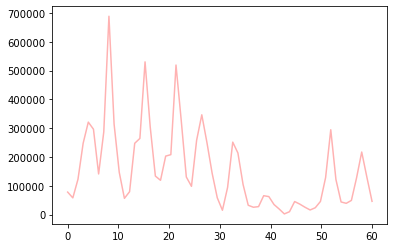

Akima done!!


/Users/ange0/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20208 (\N{CJK UNIFIED IDEOGRAPH-4EF0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ange0/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 33105 (\N{CJK UNIFIED IDEOGRAPH-8151}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ange0/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35282 (\N{CJK UNIFIED IDEOGRAPH-89D2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ange0/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26041 (\N{CJK UNIFIED IDEOGRAPH-65B9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ange0/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20301 (\N{CJK UNIFIED IDEOGRAPH-4F4D}) missing from c

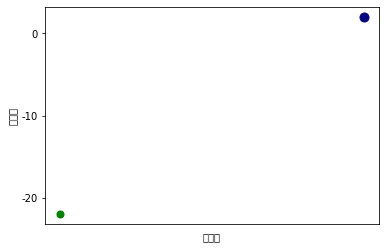

方位角2
仰腑角8
distance:73.91409386181935
(x,y,z:)2.5544605289051487cm,110.28685364740274cm,73.1501787069384cm
誤差:27.79396528051491cm


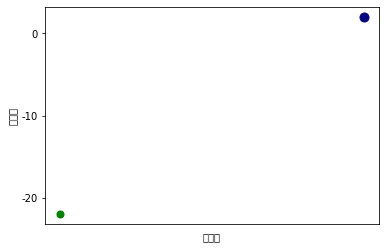

方位角2
仰腑角7
distance:74.08096134179728
(x,y,z:)2.5661171739825934cm,109.02819811754695cm,73.48398134780516cm
誤差:27.807082331075932cm


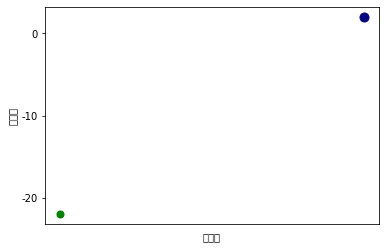

方位角2
仰腑角7
distance:74.06916002805899
(x,y,z:)2.565708384014012cm,109.02675989919034cm,73.47227513472535cm
誤差:27.818619731120197cm


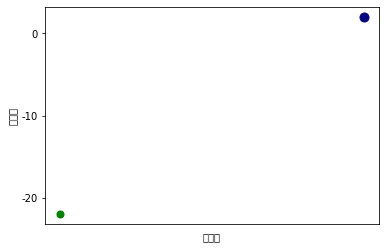

方位角2
仰腑角7
distance:73.92230218160405
(x,y,z:)2.5606213220334935cm,109.00886242986898cm,73.32660073938533cm
誤差:27.96221181050904cm


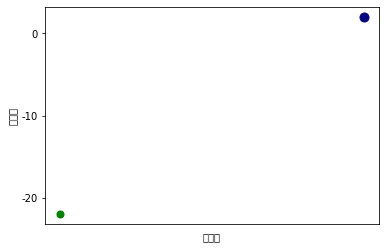

方位角2
仰腑角7
distance:73.84820349981091
(x,y,z:)2.558054591034397cm,108.99983207217167cm,73.25309918038609cm
誤差:28.03467555757385cm


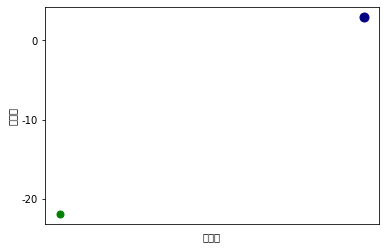

方位角3
仰腑角7
distance:72.96545094560456
(x,y,z:)3.790252513117352cm,108.89225159800132cm,72.32232628379755cm
誤差:29.088747319261934cm


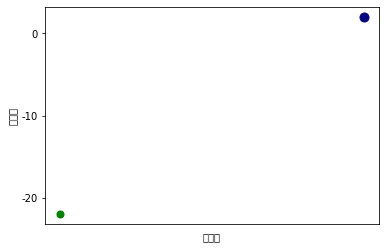

方位角2
仰腑角7
distance:73.51933495292788
(x,y,z:)2.5466627946692615cm,108.95975307829643cm,72.92688081432668cm
誤差:28.35638983356995cm


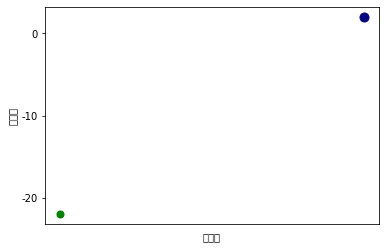

方位角2
仰腑角7
distance:73.63351691710007
(x,y,z:)2.550617984962614cm,108.9736683592988cm,73.04014264534925cm
誤差:28.244673131315437cm


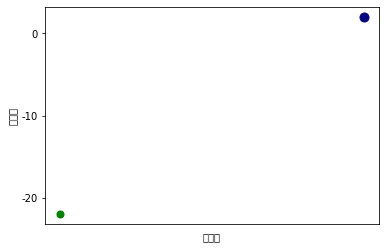

方位角2
仰腑角7
distance:73.80402863437557
(x,y,z:)2.5565244019169935cm,108.99444851032605cm,73.20928029724936cm
誤差:28.077879796429944cm


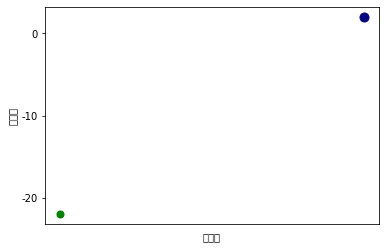

方位角2
仰腑角7
distance:73.6764908697431
(x,y,z:)2.5521065752281cm,108.97890556669094cm,73.08277029322618cm
誤差:28.202632128342405cm


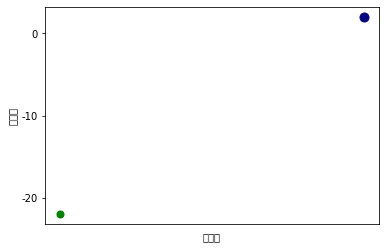

方位角2
仰腑角7
distance:73.64301819238545
(x,y,z:)2.5509471030685753cm,108.97482627347935cm,73.04956735479155cm
誤差:28.235377883559636cm


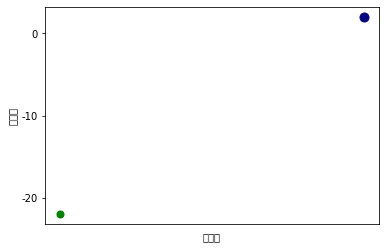

方位角2
仰腑角7
distance:73.64301819238545
(x,y,z:)2.5509471030685753cm,108.97482627347935cm,73.04956735479155cm
誤差:28.235377883559636cm


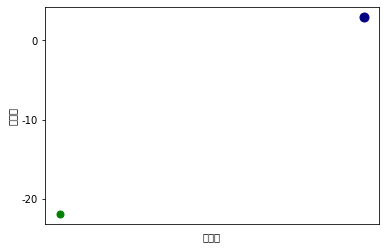

方位角3
仰腑角7
distance:73.39001171930256
(x,y,z:)3.812306684216487cm,108.94399254072748cm,72.74314493707469cm
誤差:28.676978333842868cm


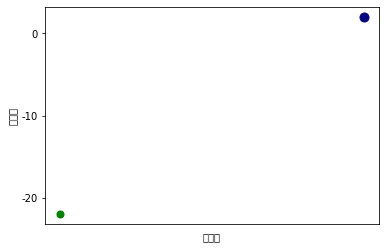

方位角2
仰腑角7
distance:73.9855689535176
(x,y,z:)2.562812842594367cm,109.01657270982145cm,73.38935767724121cm
誤差:27.900347771910223cm


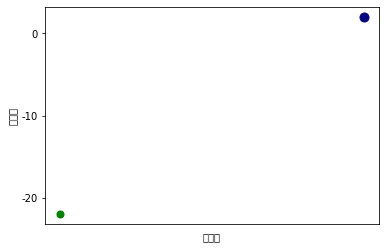

方位角2
仰腑角7
distance:73.9855689535176
(x,y,z:)2.562812842594367cm,109.01657270982145cm,73.38935767724121cm
誤差:27.900347771910223cm


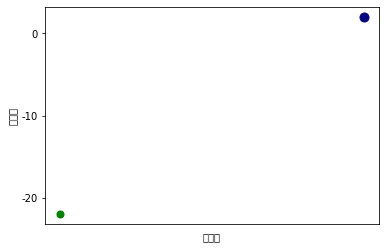

方位角2
仰腑角7
distance:74.24027470726402
(x,y,z:)2.571635687184426cm,109.04761353279204cm,73.64201088959796cm
誤差:27.65135350349971cm


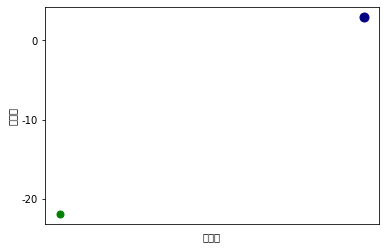

方位角3
仰腑角7
distance:72.82558221708925
(x,y,z:)3.7829869128518663cm,108.87520588789425cm,72.18369037201343cm
誤差:29.224482042748594cm


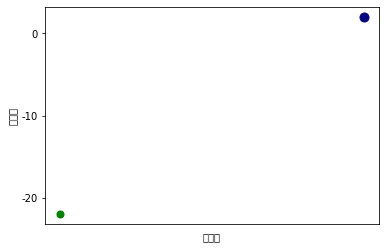

方位角2
仰腑角7
distance:73.40628643302773
(x,y,z:)2.5427468661613872cm,108.94597592940328cm,72.8147432937374cm
誤差:28.4670168359897cm


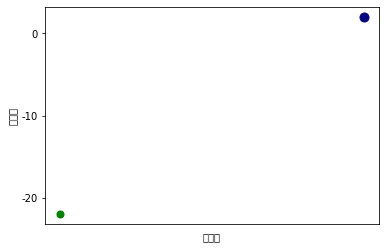

方位角2
仰腑角7
distance:73.97083875811501
(x,y,z:)2.5623025980360605cm,109.01477755057951cm,73.37474618483333cm
誤差:27.914750811939534cm


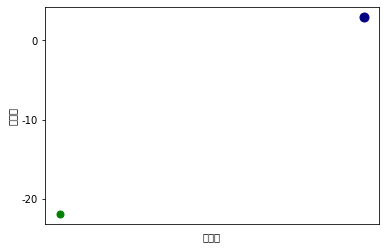

方位角3
仰腑角7
distance:73.40526986866094
(x,y,z:)3.8130992817842624cm,108.94585204137137cm,72.75826859960377cm
誤差:28.662186852429098cm


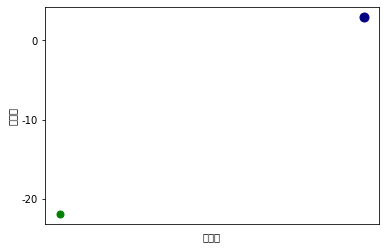

方位角3
仰腑角7
distance:73.83870989827028
(x,y,z:)3.835614693396495cm,108.99867509318537cm,73.18788824615724cm
誤差:28.242210909225292cm


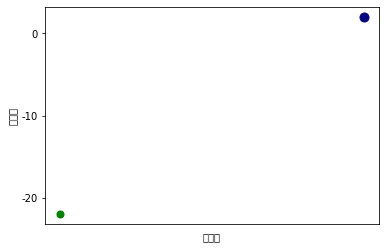

方位角2
仰腑角7
distance:74.03412041722636
(x,y,z:)2.5644946342799555cm,109.022489644825cm,73.43751788991882cm
誤差:27.85287705147455cm


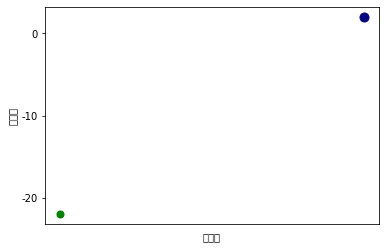

方位角2
仰腑角7
distance:75.65006247575981
(x,y,z:)2.620469834836969cm,109.21942344247924cm,75.04043791063147cm
誤差:26.27515886566197cm


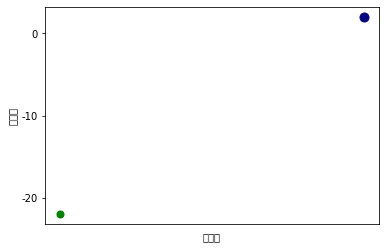

方位角2
仰腑角7
distance:75.35737457670234
(x,y,z:)2.6103313129983694cm,109.18375376039847cm,74.75010863134696cm
誤差:26.560582617301225cm


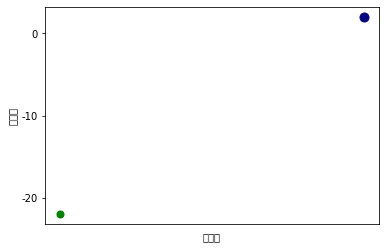

方位角2
仰腑角7
distance:75.32581098478188
(x,y,z:)2.6092379703387625cm,109.1799071261756cm,74.71879939402145cm
誤差:26.5913722741198cm


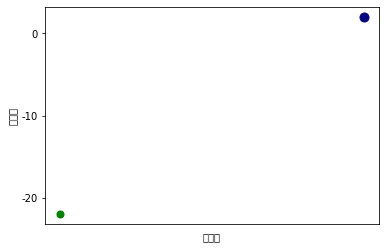

方位角2
仰腑角7
distance:75.5333435121761
(x,y,z:)2.616426764504773cm,109.20519897902436cm,74.92465952455805cm
誤差:26.388961933542536cm


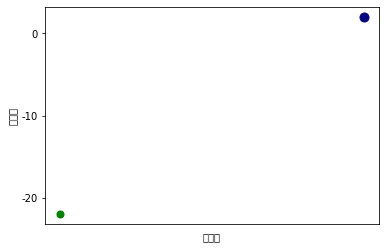

方位角2
仰腑角7
distance:75.5333435121761
(x,y,z:)2.616426764504773cm,109.20519897902436cm,74.92465952455805cm
誤差:26.388961933542536cm


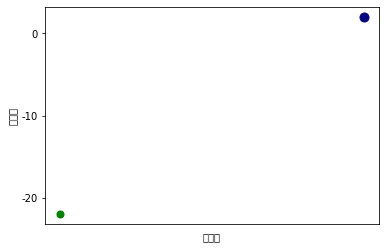

方位角2
仰腑角7
distance:75.57282271639731
(x,y,z:)2.6177942989175587cm,109.21001028372095cm,74.9638205863757cm
誤差:26.35046615151929cm


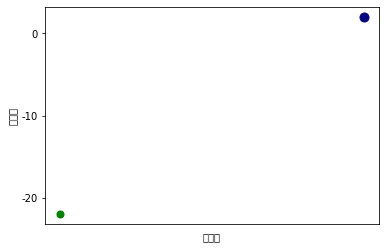

方位角2
仰腑角7
distance:75.58459327340765
(x,y,z:)2.618202023492733cm,109.21144475377531cm,74.97549629058005cm
誤差:26.338989361061067cm


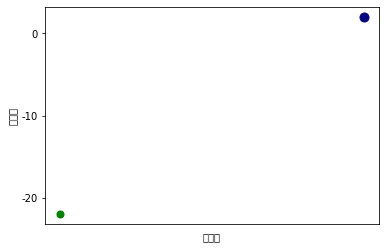

方位角2
仰腑角7
distance:75.74062823845988
(x,y,z:)2.623606974998625cm,109.23046063251448cm,75.13027385088466cm
誤差:26.186873319931877cm


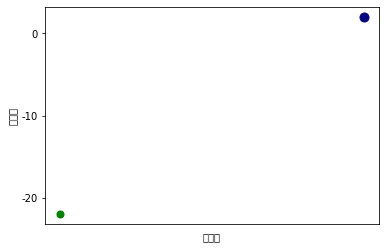

方位角2
仰腑角7
distance:75.60747537130518
(x,y,z:)2.6189946447455905cm,109.21423338002182cm,74.9981939935343cm
誤差:26.316679091308554cm


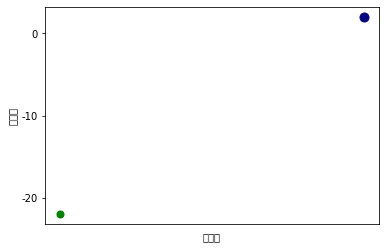

方位角2
仰腑角7
distance:75.60747537130518
(x,y,z:)2.6189946447455905cm,109.21423338002182cm,74.9981939935343cm
誤差:26.316679091308554cm


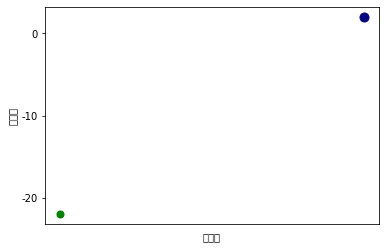

方位角2
仰腑角7
distance:75.0382096049802
(x,y,z:)2.5992756422776417cm,109.14485733485677cm,74.43351564437569cm
誤差:26.87200443697258cm


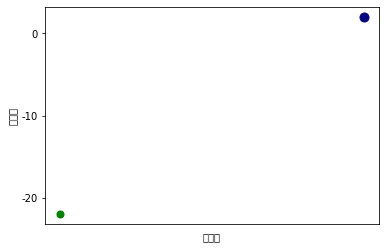

方位角2
仰腑角7
distance:75.03777335927741
(x,y,z:)2.599260531005194cm,109.14480416987941cm,74.43308291415046cm
誤差:26.872430223414675cm


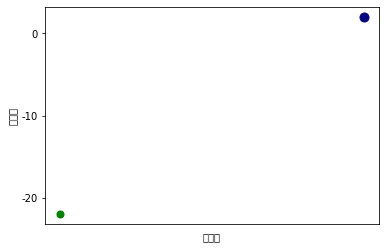

方位角2
仰腑角7
distance:75.29635940996171
(x,y,z:)2.60821778660224cm,109.17631788209003cm,74.68958515414727cm
誤差:26.62010333514156cm


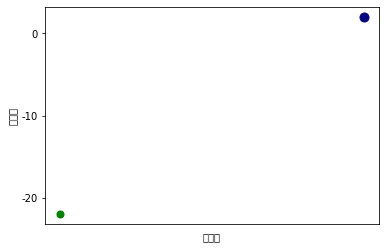

方位角2
仰腑角7
distance:75.22677545359495
(x,y,z:)2.6058074428076643cm,109.16783773101608cm,74.6205619387469cm
誤差:26.6879912046911cm


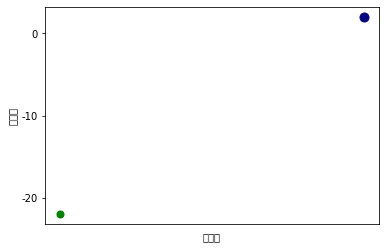

方位角2
仰腑角7
distance:75.57495767471912
(x,y,z:)2.6178682525099cm,109.21027046968983cm,74.96593834017717cm
誤差:26.348384457698664cm


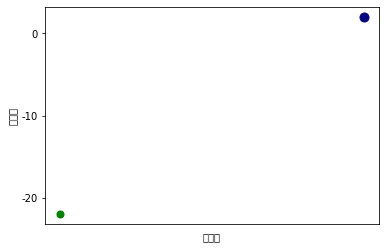

方位角2
仰腑角7
distance:75.48341535799577
(x,y,z:)2.6146972851407524cm,109.19911426765697cm,74.87513371544239cm
誤差:26.437650537044615cm


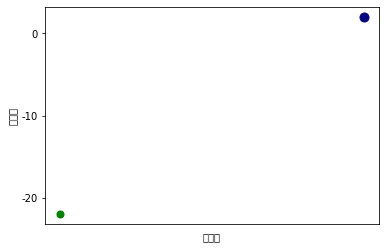

方位角2
仰腑角7
distance:75.72810726010955
(x,y,z:)2.6231732563076435cm,109.22893470910414cm,75.11785377259618cm
誤差:26.199078124427974cm


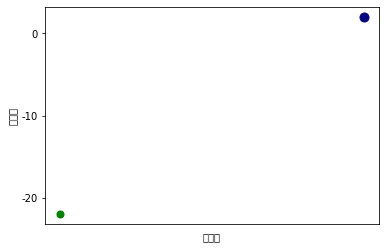

方位角2
仰腑角7
distance:75.64697631462734
(x,y,z:)2.6203629321869455cm,109.21904733404838cm,75.03737661926878cm
誤差:26.278167598491102cm


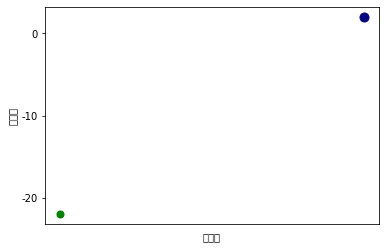

方位角2
仰腑角7
distance:75.3981411865902
(x,y,z:)2.6117434423209844cm,109.18872196037836cm,74.7905467242976cm
誤差:26.520818292062643cm


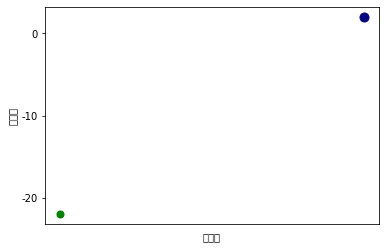

方位角2
仰腑角7
distance:75.38599693818531
(x,y,z:)2.6113227733146376cm,109.1872419487991cm,74.77850034008358cm
誤差:26.532663644802046cm


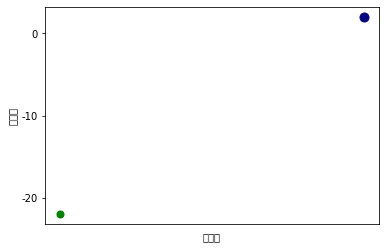

方位角2
仰腑角7
distance:75.38599693818531
(x,y,z:)2.6113227733146376cm,109.1872419487991cm,74.77850034008358cm
誤差:26.532663644802046cm


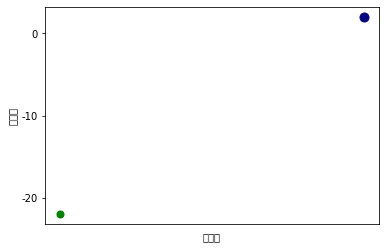

方位角2
仰腑角7
distance:74.94121009347239
(x,y,z:)2.59591564116751cm,109.1330360680787cm,74.33729780155507cm
誤差:26.966686553009794cm


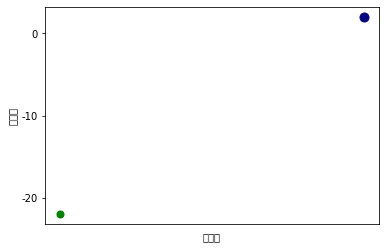

方位角2
仰腑角7
distance:74.94121009347239
(x,y,z:)2.59591564116751cm,109.1330360680787cm,74.33729780155507cm
誤差:26.966686553009794cm


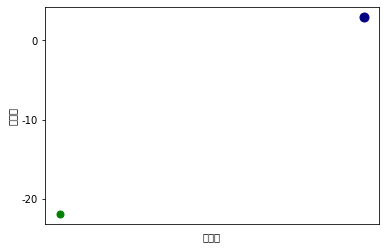

方位角3
仰腑角7
distance:73.67785776471982
(x,y,z:)3.827259092279407cm,108.97907214928425cm,73.02845387913395cm
誤差:28.398019224865447cm


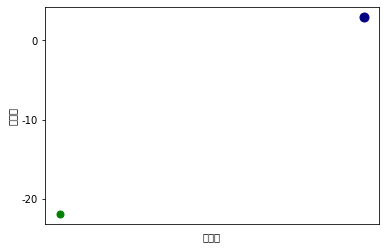

方位角3
仰腑角7
distance:73.67785776471982
(x,y,z:)3.827259092279407cm,108.97907214928425cm,73.02845387913395cm
誤差:28.398019224865447cm


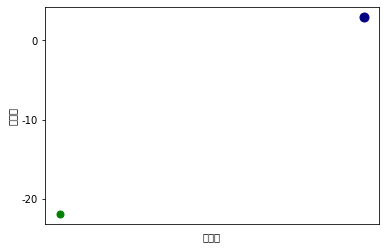

方位角3
仰腑角7
distance:73.42289542767149
(x,y,z:)3.8140148564633614cm,108.94800005667513cm,72.77573880520349cm
誤差:28.6451009775691cm


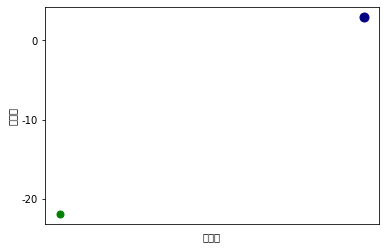

方位角3
仰腑角7
distance:73.51846132736677
(x,y,z:)3.8189791085414906cm,108.95964661012292cm,72.87046237765861cm
誤差:28.552472671690293cm


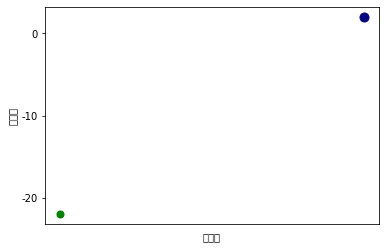

方位角2
仰腑角7
distance:73.87312764743123
(x,y,z:)2.558917947585081cm,109.00286956167709cm,73.27782247724494cm
誤差:28.010300388743776cm


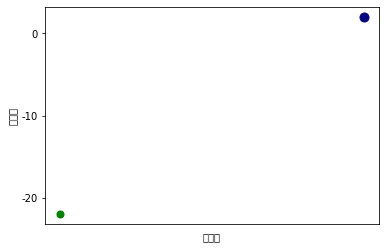

方位角2
仰腑角7
distance:73.54757710258374
(x,y,z:)2.5476410846907385cm,108.96319493053134cm,72.95489537516583cm
誤差:28.328755620204497cm


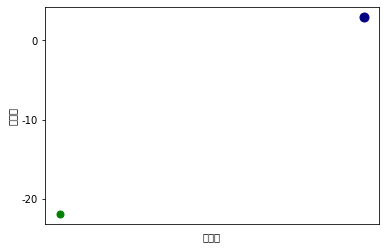

方位角3
仰腑角7
distance:72.94914390714749
(x,y,z:)3.789405430111732cm,108.89026426993168cm,72.30616297718146cm
誤差:29.104570365695867cm


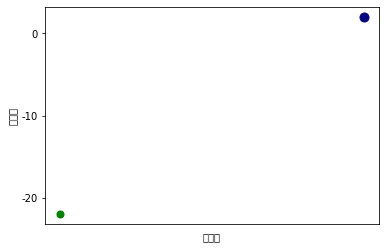

方位角2
仰腑角7
distance:73.7664986603379
(x,y,z:)2.5552243875924923cm,108.98987475703207cm,73.17205275778153cm
誤差:28.114587518052566cm


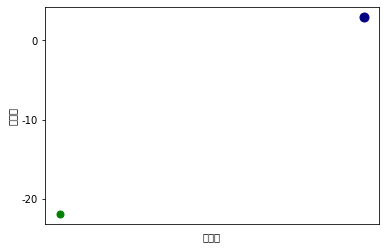

方位角3
仰腑角7
distance:72.90714313734581
(x,y,z:)3.787223664341349cm,108.88514566369344cm,72.26453240629618cm
誤差:29.145327011797537cm


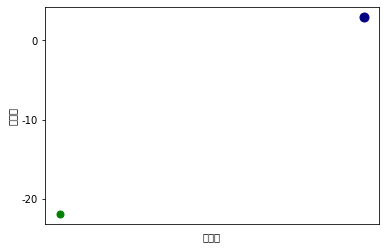

方位角3
仰腑角7
distance:73.0408791955071
(x,y,z:)3.794170697820497cm,108.90144398929115cm,72.39708970168603cm
誤差:29.015564748588915cm


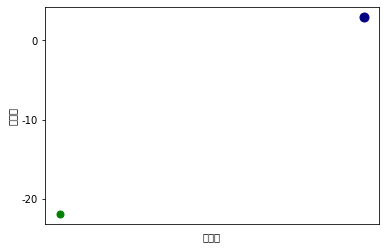

方位角3
仰腑角7
distance:73.24925427774704
(x,y,z:)3.8049949189949785cm,108.92683852374572cm,72.60362814545451cm
誤差:28.81345368656431cm


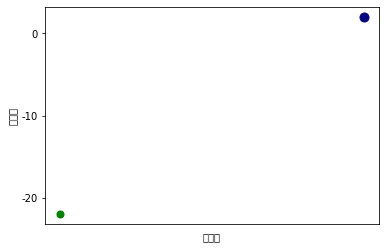

方位角2
仰腑角7
distance:74.17097226902263
(x,y,z:)2.569235094997864cm,109.0391676901472cm,73.57326692371458cm
誤差:27.719091635986246cm


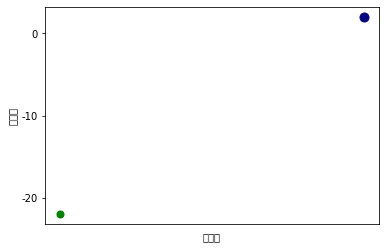

方位角2
仰腑角7
distance:74.17097226902263
(x,y,z:)2.569235094997864cm,109.0391676901472cm,73.57326692371458cm
誤差:27.719091635986246cm


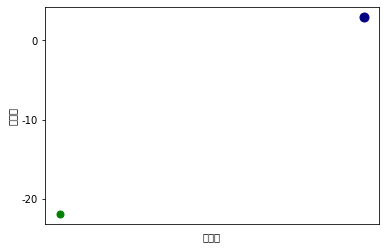

方位角3
仰腑角7
distance:73.74356014405362
(x,y,z:)3.8306720583497924cm,108.98707925511381cm,73.09357715123356cm
誤差:28.33437025591128cm


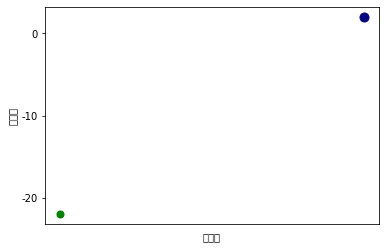

方位角2
仰腑角8
distance:74.15142594062746
(x,y,z:)2.5626626916576507cm,110.31988388876776cm,73.38505791698674cm
誤差:27.559868167553137cm


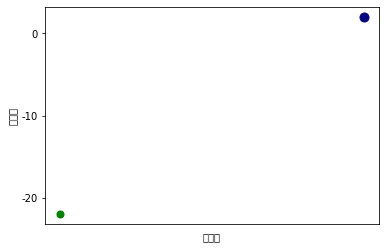

方位角2
仰腑角7
distance:74.1359509192962
(x,y,z:)2.5680219778168603cm,109.03489966125088cm,73.5385277928575cm
誤差:27.753325416141884cm


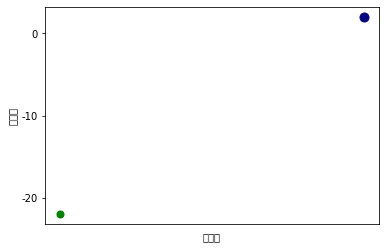

方位角2
仰腑角7
distance:74.1359509192962
(x,y,z:)2.5680219778168603cm,109.03489966125088cm,73.5385277928575cm
誤差:27.753325416141884cm


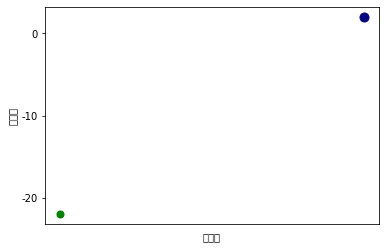

方位角2
仰腑角7
distance:74.36920470026232
(x,y,z:)2.576101739774482cm,109.06332614638397cm,73.76990190274161cm
誤差:27.52535446137142cm


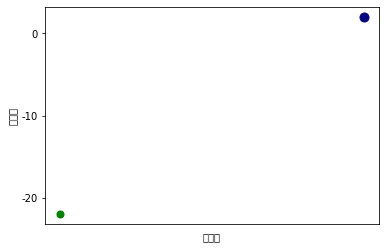

方位角2
仰腑角7
distance:74.55183657670092
(x,y,z:)2.5824279912992627cm,109.0855833732504cm,73.95106204373667cm
誤差:27.346921097653258cm


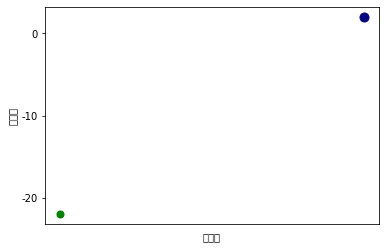

方位角2
仰腑角7
distance:74.25626603997812
(x,y,z:)2.5721896167335196cm,109.04956238601008cm,73.6578733564667cm
誤差:27.635724231188963cm


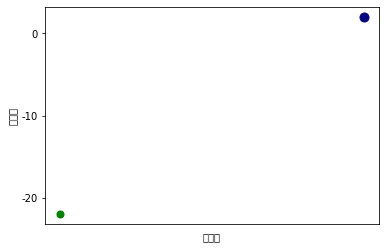

方位角2
仰腑角7
distance:74.54196811419305
(x,y,z:)2.5820861540624946cm,109.08438071020414cm,73.94127310604304cm
誤差:27.3565612784543cm


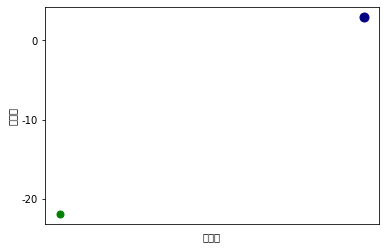

方位角3
仰腑角7
distance:73.41321047852989
(x,y,z:)3.813511763528998cm,108.94681975828233cm,72.76613922015626cm
誤差:28.654489298399245cm


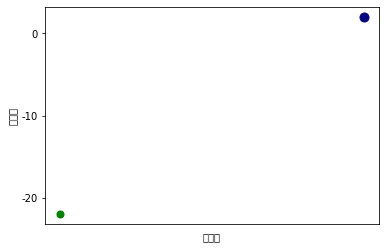

方位角2
仰腑角7
distance:74.12215011998275
(x,y,z:)2.5675439269453344cm,109.03321776690007cm,73.52483820701836cm
誤差:27.766816398913743cm


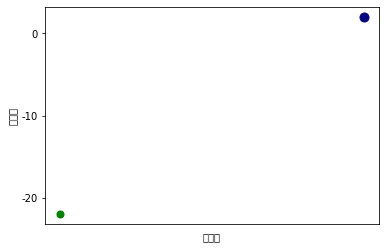

方位角2
仰腑角7
distance:74.20822414431468
(x,y,z:)2.5705254761594825cm,109.04370755172964cm,73.61021860549018cm
誤差:27.68267965345851cm


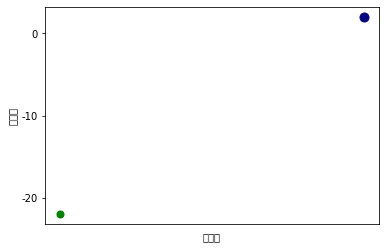

方位角2
仰腑角7
distance:74.00670013279134
(x,y,z:)2.5635448131446763cm,109.01914795276492cm,73.41031857131551cm
誤差:27.87968650985491cm


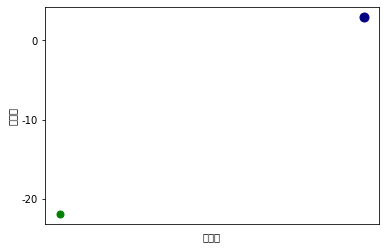

方位角3
仰腑角7
distance:73.4225044470808
(x,y,z:)3.8139945466434777cm,108.94795240812726cm,72.77535127075419cm
誤差:28.64547997947382cm


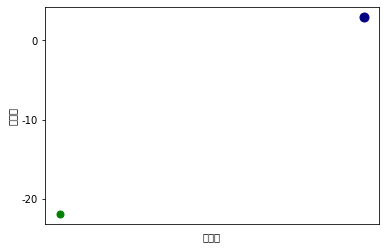

方位角3
仰腑角7
distance:73.05855460010144
(x,y,z:)3.795088861770913cm,108.90359807924348cm,72.41460931352566cm
誤差:28.998417247439434cm


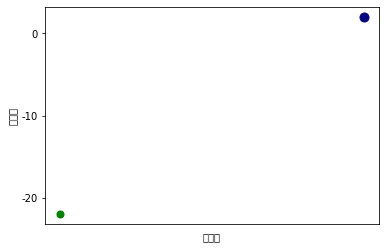

方位角2
仰腑角7
distance:73.38942208812239
(x,y,z:)2.5421626960277153cm,108.9439206827627cm,72.79801484982926cm
誤差:28.483521573864476cm


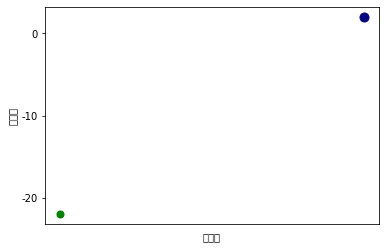

方位角2
仰腑角7
distance:73.92546663579871
(x,y,z:)2.560730936705173cm,109.00924807982392cm,73.32973969288707cm
誤差:27.959117368564407cm


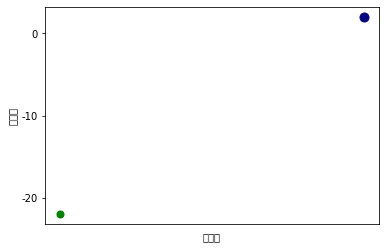

方位角2
仰腑角7
distance:73.92546663579871
(x,y,z:)2.560730936705173cm,109.00924807982392cm,73.32973969288707cm
誤差:27.959117368564407cm


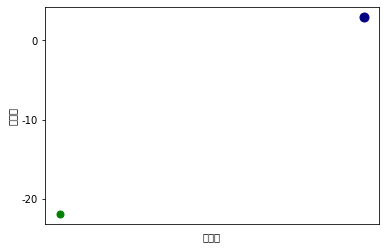

方位角3
仰腑角7
distance:73.47662909978972
(x,y,z:)3.8168060978405576cm,108.95454854401493cm,72.82899886345021cm
誤差:28.593016641857066cm


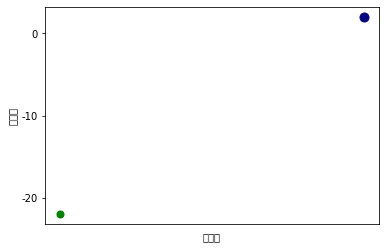

方位角2
仰腑角7
distance:73.47235700137907
(x,y,z:)2.5450355084396494cm,108.95402790618665cm,72.8802814336917cm
誤差:28.402359194077675cm


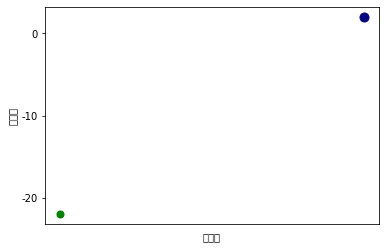

方位角2
仰腑角7
distance:73.47235700137907
(x,y,z:)2.5450355084396494cm,108.95402790618665cm,72.8802814336917cm
誤差:28.402359194077675cm


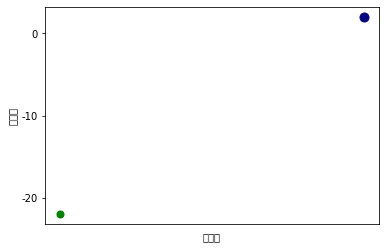

方位角2
仰腑角7
distance:74.49859719201235
(x,y,z:)2.5805838130258296cm,109.07909512439511cm,73.89825168759978cm
誤差:27.39893085192048cm


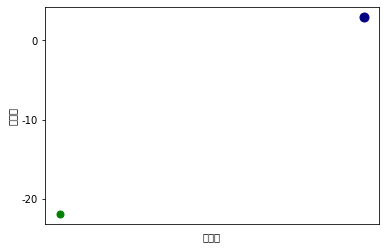

方位角3
仰腑角7
distance:73.79068587822195
(x,y,z:)3.833120044760473cm,108.9928224373944cm,73.14028751454546cm
誤差:28.28872313480977cm
[-17.08590614,-16.91903866,-16.93083997,-17.07769782,-17.1517965 ,
 -18.03454905,-17.48066505,-17.36648308,-17.19597137,-17.32350913,
 -17.35698181,-17.35698181,-17.60998828,-17.01443105,-17.01443105,
 -16.75972529,-18.17441778,-17.59371357,-17.02916124,-17.59473013,
 -17.1612901 ,-16.96587958,-15.34993752,-15.64262542,-15.67418902,
 -15.46665649,-15.46665649,-15.42717728,-15.41540673,-15.25937176,
 -15.39252463,-15.39252463,-15.9617904 ,-15.96222664,-15.70364059,
 -15.77322455,-15.42504233,-15.51658464,-15.27189274,-15.35302369,
 -15.60185881,-15.61400306,-15.61400306,-16.05878991,-16.05878991,
 -17.32214224,-17.32214224,-17.57710457,-17.48153867,-17.12687235,
 -17.4524229 ,-18.05085609,-17.23350134,-18.09285686,-17.9591208 ,
 -17.75074572,-16.82902773,-16.82902773,-17.25643986,-16.84857406,
 -16.86404908,-16.86404908,-16.6307953 ,-16.44816342,-16.74373396,
 

In [4]:
if __name__ == '__main__':
    #speaker_heights = [0,17,34,50,64,75]
    speaker_heights = [0,10,20,30,40,50]
    houi = -22
    gyouhu = 3
    cdf_array = np.zeros(100*3).reshape(100,3)
    error_array = np.zeros(100)
    distance_error_array = np.zeros(100)
    deg_array = np.zeros(80*2).reshape(80,2)
    #データベース作成
    db1 = create_db()
    #計測信号読み込み
    test_number = 9
    #スピーカマイク間距離の真値db
    distance_db =[91,83,83,135,135,140,140,91,91]
    #-0.3759 0.3893 -0.7477
    dx = 0.0
    dy = 117.0
    dz = 100.0
    signal = readwav('vivesound_0817/test0826_'+str(test_number)+'.wav')
    sec = 150000
    for i in range(0,80):
        # 残差平方和によって測位
        #cdf_array[i,:] = estimate(db1,signal)
        distance_error_array[i] = estimate(db1,signal) - distance_db[test_number-1]
        sec += 48000*3
    #print(cdf_array[0,0])
    #print(cdf_array[0,1])
    #print(cdf_array)
    #print(np.array2string(deg_array,separator=','))
    #print(np.average(deg_array[:,0]))
    #print(np.average(deg_array[:,1]))
    #print(np.array2string(np.sort(cdf_array),separator=',',precision=2))
    print(np.array2string(distance_error_array,separator=','))
    print(np.average(distance_error_array))
    print(np.std(distance_error_array))

In [ ]:
'''

y=rsinθ

https://manabitimes.jp/math/1235

スピーカ・マイク間距離の誤差の平均値と標準偏差
1
-14.595714531318906
7.341509120057439
2
-21.578613494745014
10.81839479444456
3
-20.340774253386886
10.179585036870005
4
-37.76967067820094
18.934800539066522
5
-33.920463800600906
17.083132232400494
6
-30.880413092324737
16.645435542475578
7
-28.835234958161017
14.66341535056449
8
-25.872434228495603
13.12609688795215
9
-13.415589991784191
6.749863627165843
'''



In [ ]:
"""
6/14のテストデータを解析
方位，高さ，距離，方位角，仰俯角(これから)
ans.
-0.2149 0.6218 -1.0525 -12 30
0.2497 0.6229 -1.0482 14 30
0.2523 0.5334 -1.0434 14 27
-0.4294 0.5280 -1.0255 -23 27
-0.0082 0.2315 -1.2317 -1 10
-0.2330 0.2319 -1.6660 -8 8
0.4514 0.3436 -0.7841 30 23
-0.5441 0.0908 -1.1785 -25 4
-0.5219 0.0977 -1.9388 -16 3
-0.6911 0.0894 -1.7950 -22 3
estimate.
-13cm,158cm,99cm
32cm,156cm,105cm
14cm,145cm,92cm
-46cm,145cm,91cm
-7cm,120cm,106cm
-23cm,133cm,130cm
24cm,141cm,73cm
-37cm,139cm,44cm
-39cm,102cm,147cm
-65cm,100cm,123cm
"""